In [1]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Видео поток
# ipython notebook должен лежать в папке с картинками
videoCapture = cv2.VideoCapture("%02d.tif")

In [3]:
# Считывание кадра
def readFrame(videoCapture):
    retVal, frame = videoCapture.read()
    if retVal == False:
        return False, None
    else:
        # Так как видео уже в grayscale, то нужно просто дропнуть лишние каналы
        frameGray, _, _ = cv2.split(frame)
        return True, frameGray

# Перевод матрицы преобразования в дельты по X, Y и углу
def displacementAndRotation(transform):
    dx = transform[0 ,2]
    dy = transform[1, 2]
    rot = np.arctan2(transform[1, 0],transform[0, 0])
    return (dx, dy, rot)

def writeTrajectoryToFile(trajectory):
    out = open('results.txt', 'w')
    for i, accumulatedDisplacement in enumerate(trajectory):
        strX = str(round(accumulatedDisplacement[0]))
        strY = str(round(accumulatedDisplacement[1]))
        out.write(str(i + 1).zfill(2) + " frame | x: " + strX + " y: " + strY + "\n")
    out.close()

In [4]:
# Параметры для поиска особых точек 
featureParameters = {'maxCorners' : 100, 'qualityLevel' : 0.3, 'minDistance' : 3, 'blockSize' : 3}
# Параметры для подсчета оптического потока методом Lucas-Kanade с пирамидами
lkParameters = {'winSize' : (15, 15), 'maxLevel' : 2, 'criteria' : (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)}

In [5]:
# Подсчет траектории сдвига камеры для каждого кадра относительно первого
def processFrames(videoCapture, featureParameters, lkParameters):
    # Перемещения между кадрами
    frameToFrameMismatch = []
    
    # Время после обработки каждого кадра
    elapsedTime = []
    
    # Считываем по кадру, ищем ключевые точки (с помощью поиска углов)
    # Считаем перемещение между соседними кадрами
    retVal, frame = readFrame(videoCapture)
    features = cv2.goodFeaturesToTrack(frame, mask = None, useHarrisDetector = 1, **featureParameters)
    
    while(True):
        newRetVal, newFrame = readFrame(videoCapture)
        if newRetVal == False:
            break
        newFeatures, status, error = cv2.calcOpticalFlowPyrLK(frame, newFrame, features, None, **lkParameters)
        
        matchedKeyPoints = features[status == 1]
        newMatchedKeyPoints = newFeatures[status == 1]
        
        transform = cv2.estimateRigidTransform(matchedKeyPoints, newMatchedKeyPoints, False)
        frameToFrameMismatch.append(displacementAndRotation(transform))
        
        frame = newFrame
        features = newFeatures
        
        elapsedTime.append(time.perf_counter())
    
    # Складываем перемещения от кадра к кадру
    # Чтобы получить итоговую тракеторию движения изображения
    
    # X Y Angle
    trajectory = [(0.0, 0.0, 0.0)]
    
    totalX, totalY, totalAngle = 0.0, 0.0, 0.0
    
    for frameMismatch in frameToFrameMismatch:
        totalX += frameMismatch[0]
        totalY += frameMismatch[1]
        totalAngle += frameMismatch[2]
        
        trajectory.append((totalX, totalY, totalAngle))
    
    return trajectory, elapsedTime

In [6]:
trajectory, elapsedTime = processFrames(videoCapture, featureParameters, lkParameters)
writeTrajectoryToFile(trajectory)

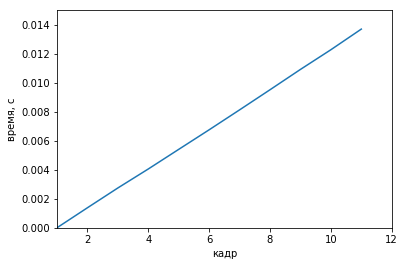

In [11]:
plt.plot(range(1, len(elapsedTime) + 1), elapsedTime)
plt.ylabel('время, c')
plt.xlabel('кадр')
plt.axis([1, 12, 0, 0.015])
plt.show()